In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import sys
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import os
from multiprocessing import Pool
from tqdm.auto import tqdm

pd.set_option('display.max_columns', 50)

In [4]:
def resample_data1(data,sampling_freq):
    # Fix datetime type
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.sort_values(by=["ticker", "date", "datetime"])
    
    # Resample on a given basis
    resample=(
    data.set_index("datetime")
    .groupby(["ticker", "ticker_desc", "date"])
    .resample(sampling_freq,label = 'right')["price"]
    .last()
    .reset_index().copy()
    )
    
    # Forward fill missing prices for particular intervals using last observed price
    resample["price"] = (
    resample.sort_values(by="datetime")
    .groupby(["ticker", "ticker_desc", "date"])["price"]
    .fillna(method="ffill")
    )
    
    
    # Add returns
    resample = resample.sort_values(by=["ticker", "date", "datetime"])
    resample["log_price"] = np.log(resample["price"])
    resample["return"] = resample.groupby(["ticker", "date"])["log_price"].diff(1).fillna(0)
    
    return resample

In [5]:
def explore_data(ticker_df): 
    temp_df = ticker_df.query("date >= '2020-09-10'")[["ticker", "ticker_desc", "date", "datetime", "price"]] .copy() # use 1 month data to plot signature figure 
    L =120; step=5
    rv = {}
    for i in tqdm(range(1,L+1)):
        df = resample_data1(temp_df, sampling_freq = str(i*step)+'s')
        df['return_sq'] = np.square(df['return'])
        rv[i] = df.groupby(['ticker','date'])['return_sq'].sum() #daily rv with sample freq = i
    return rv

In [6]:
def import_data(num):
    ## Read in all files from TAQ

    # Fix forward/backslashes in directory name
    taq_folder = '../data/taq{}/'.format(str(num))
    if sys.platform != 'linux':
        taq_folder = taq_folder.replace('/', '\\')
    print(f'Reading data from: {taq_folder}')

    # Read files
    taq_files = [x[2] for x in tqdm(os.walk(taq_folder))][0]
    ticker_df = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files]).astype({'DATE':np.int32,'PRICE':np.float32})
    
    
    # Sort columns
    ticker_df = ticker_df.sort_values(by = ['DATE'])
    # Rename columns
    ticker_df.rename(columns = {'SYM_ROOT': 'ticker', 'PRICE': 'price','SIZE':'size'}, inplace = True)
    
    
    ticker_desc_dict = {
    'FB':'Facebook',
    'AMZN' :'Amazon',
    'NFLX':'Netflix',
    'AAPL':'Apple',
    'GOOG':'Google'
    }

    ticker_df["ticker_desc"] = ticker_df["ticker"].apply(lambda x: ticker_desc_dict.get(x, "NA"))
    
    # Convert date and time info to pandas datetime
    ticker_df["datetime"] = pd.to_datetime(ticker_df['DATE'].astype(str) + ' ' + ticker_df['TIME_M'])
    ticker_df['date'] = (ticker_df['datetime'].dt.date).astype(str)
    
    # Drop weird exchange
    ticker_df = ticker_df.query('EX != ["D","A","M","L"]').copy()
    ticker_df.to_csv('../data/clean/ticker{}.csv'.format(str(num)), index = False)
    
    
    for i in tqdm([1,5]):
        df = resample_data(ticker_df,sampling_freq=str(i)+'s')
        df.to_csv('../data/clean/ticker{}_{}s.csv'.format(str(num),str(i)), index = False)
        
    #result1=explore_data(ticker_df)
    
    #return result1

### Import data

In [81]:
## Read in all files from TAQ

# Fix forward/backslashes in directory name
taq_folder = '../data/clean/ticker_1s/'
if sys.platform != 'linux':
    taq_folder = taq_folder.replace('/', '\\')
print(f'Reading data from: {taq_folder}')

# Read files
taq_files = [x[2] for x in tqdm(os.walk(taq_folder))][0]
ticker_1s_df = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files])

Reading data from: ..\data\clean\ticker_1s\


### Calculate RV

In [82]:
def explore_data(ticker_df): 
    temp_df = ticker_df.query("date >= '2020-09-10'")[["ticker", "ticker_desc", "date", "datetime", "price"]] .copy() # use 1 month data to plot signature figure
    
    L =120; step=5
    rv = {}
    for i in tqdm(range(1,L+1)):
        df = resample_data1(temp_df, sampling_freq = str(i*step)+'s')
        df['return_sq'] = np.square(df['return'])
        rv[i] = df.groupby(['ticker','date'])['return_sq'].sum() #daily rv with sample freq = i
    return rv

In [83]:
k1=explore_data(ticker_1s_df)

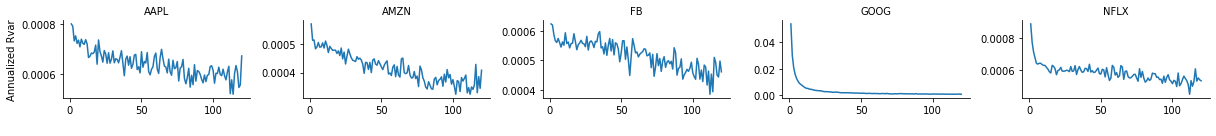

In [78]:
df_rv1=(pd.melt(pd.DataFrame.from_dict(k1).reset_index().rename(columns={0:'daily_rv','index':'freq(s)'}), 
                id_vars=['ticker','date']).rename(columns={'variable':'freq','value':'realized_var'})
        .groupby(['ticker','freq']).mean().reset_index())
df_rv1['realized_vol']=np.sqrt(df_rv['realized_var'])

# Plot RV
g = sns.FacetGrid(df_rv1, col = 'ticker', col_wrap = 5, sharex = True, aspect = 1.7, height = 2, sharey=False)
g = (g.map(plt.plot,'freq', 'realized_var')
    .set_titles("{col_name}")
    .set_axis_labels(" ", "Annualized Rvar")
)


# # Plot settings
ax = g.axes.flatten()
for i in range(3):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(3))
    #ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
   

plt.tight_layout()
plt.savefig("../exhibits/sign_rv1.pdf")